<a href="https://colab.research.google.com/github/HatemGamal/ElectroPi/blob/main/NLP_Twitter_Disaster_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np #for linear algebra

#Libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for formattting and handling text
import string
import re


#Library for nltk
import nltk
import nltk.corpus
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

stop=set(stopwords.words('english'))

#Library for NN
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant

#Library for Splitting Dataset
from sklearn.model_selection import train_test_split

#Library for TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#Library for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
train_data = pd.read_csv('https://raw.githubusercontent.com/HatemGamal/ElectroPi/main/sample_data/NLP-Disaster%20Tweets/train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/HatemGamal/ElectroPi/main/sample_data/NLP-Disaster%20Tweets/test.csv')

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in train'.format(test_data.shape[0],test_data.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


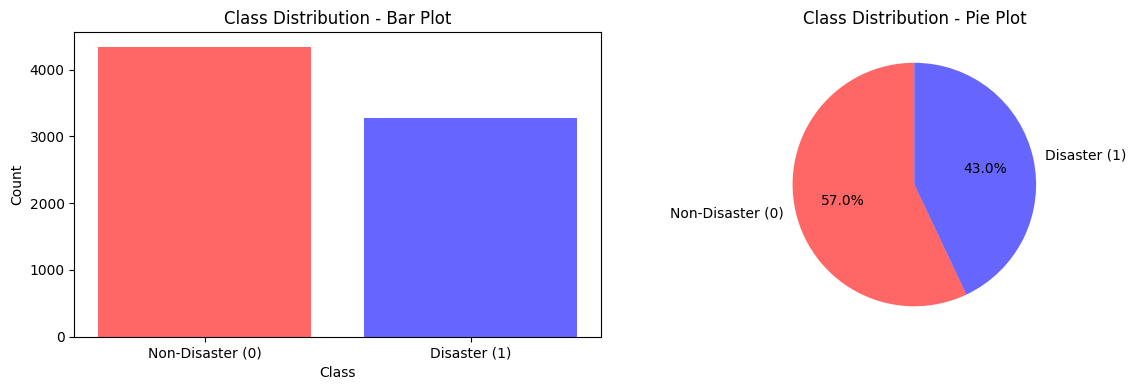

In [8]:
target_counts = train_data['target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(target_counts.index, target_counts.values, color=['red', 'blue'], alpha=0.6)
axes[0].set_xticks(target_counts.index)
axes[0].set_xticklabels(['Non-Disaster (0)', 'Disaster (1)'])
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution - Bar Plot')

colors_with_alpha = [(1, 0, 0, 0.6), (0, 0, 1, 0.6)]
axes[1].pie(target_counts, labels=['Non-Disaster (0)', 'Disaster (1)'], colors=colors_with_alpha, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution - Pie Plot')

plt.tight_layout()
plt.show()

# **Data Cleaning**

In [ ]:
!pip install text_hammer
import text_hammer as th

In [10]:
def text_cleaning(df,col_name):
    df[col_name] = df[col_name].progress_apply(lambda x:str(x).lower())
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_emails(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_html_tags(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_urls(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_special_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_accented_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda text: th.cont_exp(text))
    df[col_name] = df[col_name].progress_apply(lambda x: re.sub("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", "", x))
    df[col_name] = df[col_name].progress_apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))
    df[col_name] = df[col_name].progress_apply(lambda x:re.compile(r'(\S*?)([a-z])\2{2,}').sub(r'\1\2', x))#remove words with characters repeated more than 3 times
   # df[col_name] = df[col_name].progress_apply(lambda x:th.spelling_correction(x))
    df[col_name] = df[col_name].progress_apply(lambda x: ' '.join(x.split()))

    return(df)

In [11]:
train_data = text_cleaning(train_data,'text')
train_data.head()

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [12]:
test_data = text_cleaning(test_data,'text')
test_data.head()

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan


# **Remove Stop Words**

In [13]:
stop.remove('not')

In [14]:
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


# **Lemmatization**

In [15]:
def word_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [16]:
train_data['text'] = train_data['text'].apply(lambda text: word_lemmatizer(text))
test_data['text'] = test_data['text'].apply(lambda text: word_lemmatizer(text))
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


In [17]:
import plotly.express as px

In [18]:
#Analysis for Non-Disaster Tweets
freqw=train_data[train_data['target']==0]['text'].str.split(expand=True).stack().value_counts()
freq100=freqw[:100]

fig=px.treemap(freq100,path=[freq100.index],values=0)
fig.update_traces(textinfo="label+value")
fig.update_layout(title={
        'text': "Non-Disaster Tweets",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [19]:
#Analysis for Disaster Tweets
freqw=train_data[train_data['target']==1]['text'].str.split(expand=True).stack().value_counts()
freq100=freqw[:100]

fig=px.treemap(freq100,path=[freq100.index],values=0)
fig.update_traces(textinfo="label+value")
fig.update_layout(title={
        'text': "Disaster Tweets",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [20]:
X = train_data.text
y= train_data.target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size= 0.2, random_state= 42,stratify=y)

## **Victorization**

In [21]:
cv=CountVectorizer()
X_train=cv.fit_transform(X_train).toarray()
X_test=cv.transform(X_test).toarray()
print(len(cv.get_feature_names_out()))

13783


In [22]:
cv.get_feature_names_out()

array(['aa', 'aace', 'aaemiddleaged', ..., 'zumiez', 'zurich',
       'zxathetis'], dtype=object)

In [23]:
pd.DataFrame(X_train, columns=cv.get_feature_names_out() ).T

,0,1,2,3,4,5,6,7,8,9,...,6080,6081,6082,6083,6084,6085,6086,6087,6088,6089
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aace,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaemiddleaged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zourryart,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zrnf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zumiez,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zurich,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#tfidf=TfidfVectorizer()
#X_train=tfidf.fit_transform(X_train).toarray()
#X_test=tfidf.transform(X_test).toarray()

In [ ]:
#from gensim.models import Word2Vec
#X_train = Word2Vec(sentences=X_train,min_count=1,vector_size=100)
#X_test = Word2Vec(sentences=X_test,min_count=1,vector_size=100)

In [ ]:

def train_model(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)
    accuracy=round(accuracy_score(y_test,y_pred),3)
    precision=round(precision_score(y_test,y_pred,average='weighted'),3)
    recall=round(recall_score(y_test,y_pred,average='weighted'),3)

    print(f'Accuracy of the model: {np.round(accuracy*100,2)}%')
    print(f'Precision Score of the model: {np.round(precision*100,2)}%')
    print(f'Recall Score of the model: {np.round(recall*100,2)}%')
    print('-'*50)
    print(classification_report(y_test,y_pred))

    conf_matrix_train = confusion_matrix(y_test, y_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train,
                                    display_labels=[0, 1])
    disp_train.plot(cmap='terrain', values_format='d')
    plt.title('Confusion Matrix ')
    plt.show()

**LOGISTIC REGRESSION**

Accuracy of the model: 80.8%
Precision Score of the model: 80.8%
Recall Score of the model: 80.8%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       869
           1       0.80      0.73      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



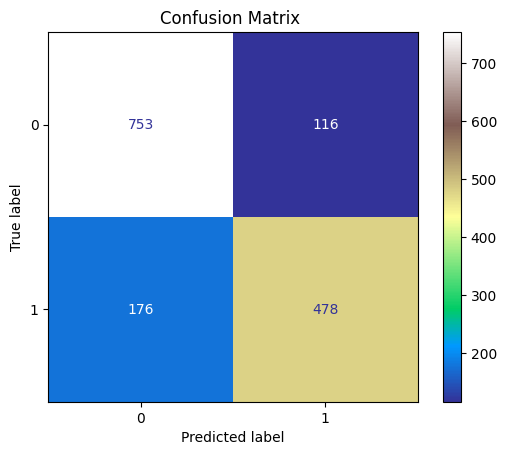

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()
train_model(logreg)

**K-Nearest Neighbors**

Accuracy of the model: 71.5%
Precision Score of the model: 74.9%
Recall Score of the model: 71.5%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.94      0.79       869
           1       0.84      0.42      0.56       654

    accuracy                           0.72      1523
   macro avg       0.76      0.68      0.67      1523
weighted avg       0.75      0.72      0.69      1523



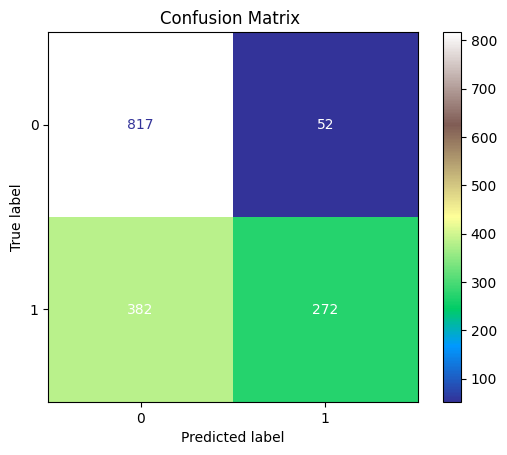

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5,weights = 'distance',algorithm = 'brute')
train_model(knn)

**Decision Tree**

Accuracy of the model: 75.9%
Precision Score of the model: 75.9%
Recall Score of the model: 75.9%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       869
           1       0.72      0.72      0.72       654

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



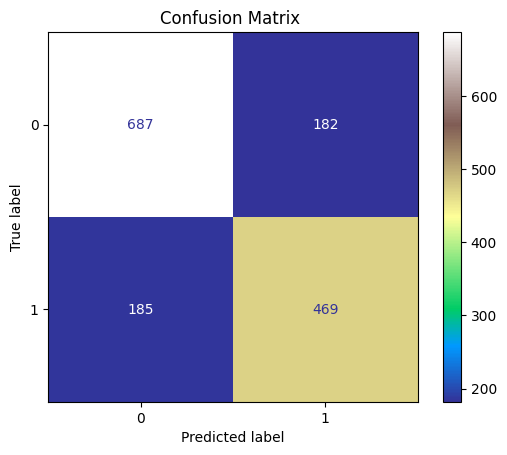

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None,
                                           splitter='best',
                                           random_state=42)
train_model(dt)

**Random Forest**

Accuracy of the model: 78.5%
Precision Score of the model: 78.6%
Recall Score of the model: 78.5%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       869
           1       0.80      0.67      0.73       654

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



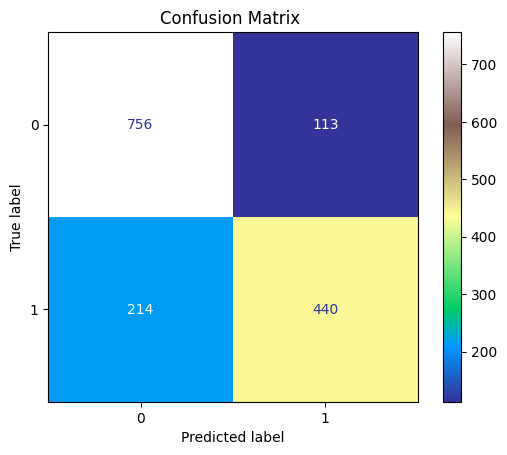

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
train_model(rf)

**Neural Network**

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, KFold
import sklearn.metrics as sk
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Define a function to create the neural network model
def create_model():
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


Epoch 1/10
134/134 [==============================] - 14s 88ms/step - loss: 0.6462 - accuracy: 0.6169 - val_loss: 0.5469 - val_accuracy: 0.7811
Epoch 2/10
134/134 [==============================] - 10s 73ms/step - loss: 0.4005 - accuracy: 0.8517 - val_loss: 0.4940 - val_accuracy: 0.7882
Epoch 3/10
134/134 [==============================] - 10s 75ms/step - loss: 0.1840 - accuracy: 0.9470 - val_loss: 0.7031 - val_accuracy: 0.7712
Epoch 4/10
134/134 [==============================] - 10s 78ms/step - loss: 0.0965 - accuracy: 0.9707 - val_loss: 0.8796 - val_accuracy: 0.7707
Epoch 5/10
134/134 [==============================] - 10s 74ms/step - loss: 0.0676 - accuracy: 0.9794 - val_loss: 1.0894 - val_accuracy: 0.7663
Epoch 6/10
134/134 [==============================] - 10s 74ms/step - loss: 0.0576 - accuracy: 0.9805 - val_loss: 1.1900 - val_accuracy: 0.7586
Epoch 7/10
134/134 [==============================] - 11s 78ms/step - loss: 0.0366 - accuracy: 0.9838 - val_loss: 1.5668 - val_accuracy:

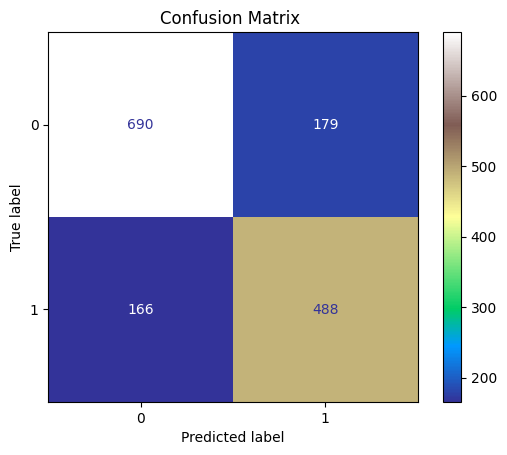

In [ ]:
# Create and compile the model
model = create_model()

epoch=[10]
for e in epoch:
  # Fitting the ANN to the Training set
  history=model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=e,validation_split=0.3
    )
  # Predicting the Test set results
  y_pred = model.predict(X_test)
  pre_score = sk.average_precision_score(y_test, y_pred)
  model.summary()
  test_results = model.evaluate(X_test, y_test)
  print("For epoch = {0}, the model test accuracy is {1}.".format(e,test_results[1]))
  print("The model test average precision score is {}.".format(pre_score))

  y_pred = tf.squeeze(tf.round((y_pred)))

  accuracy=round(accuracy_score(y_test,y_pred),3)
  precision=round(precision_score(y_test,y_pred,average='weighted'),3)
  recall=round(recall_score(y_test,y_pred,average='weighted'),3)
  print(f'Accuracy of the model: {np.round(accuracy*100,2)}%')
  print(f'Precision Score of the model: {np.round(precision*100,2)}%')
  print(f'Recall Score of the model: {np.round(recall*100,2)}%')
  print('-'*50)
  print(classification_report(y_test,y_pred))

  conf_matrix_train = confusion_matrix(y_test, y_pred)
  disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train,
                                  display_labels=[0, 1])
  disp_train.plot(cmap='terrain', values_format='d')
  plt.title('Confusion Matrix ')
  plt.show()

